In [1]:
import pandas as pd
import os
from rdflib import Graph, Namespace
from collections import defaultdict
from tqdm.notebook import tqdm
import json

VIOLATION_LIST_FILE = "./json/violation_list.json" # path to store the violation list
STUDY_CSV_FILE = "./csv/study.csv" # path to store the tabluraized study csv file
STUDY_TTL_PATH = './ttl/study.ttl' # contains the actual study data
OMICS_MODEL_TTL_PATH = './ttl/omics_model.ttl' # contains the ontology
VIOLATION_REPORT_TTL_PATH = './ttl/violation_report.ttl' # contains the shacl violation test case result


In [2]:
print("Reading study graph...")
study_graph = Graph()
study_graph.parse(STUDY_TTL_PATH, format="ttl")

print("Reading violations graph...")
violations_graph = Graph()
violations_graph.parse(VIOLATION_REPORT_TTL_PATH, format="ttl")

Reading study graph...
Reading violations graph...


<Graph identifier=N79f4a371aefd4a08a50eac2ea299809b (<class 'rdflib.graph.Graph'>)>

In [3]:
from rdflib import Graph, Namespace
from rdflib.namespace import NamespaceManager

def tabularize_graphs(study: Graph, violations: Graph):
    """
    Converts two RDF graphs (study graph and violations graph) into a tabular format (pandas DataFrame),
    using the subjects (focus nodes) of the study graph as indices. The columns of the DataFrame include
    both the properties of the study graph and the violation types (source shapes) from the violations graph.
    The resulting DataFrame includes information about each focus node from the study graph and counts the 
    number of times each focus node violates each source shape.

    The DataFrame and a list of unique violation types are then saved to disk.

    Parameters:
    study (Graph): An RDF graph representing the study, where each triple represents a property of a focus node.
    violations (Graph): An RDF graph representing the violations, where each triple represents a focus node's 
    violation of a source shape.

    Returns:
    None, but saves DataFrame and list of unique violation types to disk.
    """

    
    SH = Namespace("http://www.w3.org/ns/shacl#")

    # Create a dictionary to hold violation counts for each focusNode-sourceShape pair
    violation_counts = defaultdict(lambda: defaultdict(int))
    current_focus_node = None
    violation_list = []

    for s, p, o in tqdm(sorted(violations, key=lambda x: str(x[0])), desc="Processing violations"):  # sorting triples based on subject
        if p == SH.focusNode:
            current_focus_node = str(o)
        elif current_focus_node and p == SH.sourceShape:
            violation_list += [str(o)]
            violation_counts[current_focus_node][str(o)] += 1

    violation_list = list(set(violation_list))
    
    # Save violation_list to a JSON file
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)  

    # Initialize study DataFrame with indices as focusNodes and columns as sourceShapes
    study_df = pd.DataFrame(violation_counts).T.fillna(0)

    for s, p, o in tqdm(study, desc="Processing study"):
        if str(s) in study_df.index:
            if str(p) not in study_df.columns:
                study_df[str(p)] = ""
            study_df.at[str(s), str(p)] = str(o)

    # After creating your DataFrame and before saving to csv, just add the following line:
    study_df['focus_node'] = study_df.index

    study_df.to_csv(STUDY_CSV_FILE)

tabularize_graphs(study_graph, violations_graph)

study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

Processing violations:   0%|          | 0/142384 [00:00<?, ?it/s]

Processing study:   0%|          | 0/59163 [00:00<?, ?it/s]

,http://data.boehringer.com/ontology/omics/c97b9e6d-b7e4-49a7-add1-8ebadc861dff,http://data.boehringer.com/ontology/omics/TranscriptOmicsCalculatedResultShape-hasResultSpecies,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isMeasuredOnPlatform,http://data.boehringer.com/ontology/omics/ece15faa-30b3-471c-ae51-2d6d1f80e3a9,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isPreparedByLibrary,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasStrandedness,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasSequencingProtocol,http://data.boehringer.com/ontology/omics/f9674438-5362-4072-89d2-f804799af748,http://data.boehringer.com/ontology/omics/9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,http://data.boehringer.com/ontology/omics/248e9792-8549-4e0d-8665-06c42aff8ffc,...,http://data.boehringer.com/ontology/omics/isPartOfProject,http://data.boehringer.com/ontology/omics/hasContactCompBio,http://data.boehringer.com/ontology/omics/sourceStudyId,http://data.boehringer.com/ontology/omics/sequencingDate,http://data.boehringer.com/ontology/omics/hasStudyType,http://data.boehringer.com/ontology/omics/technicalStudyTitle,http://data.boehringer.com/ontology/omics/hasContactScientist,http://data.boehringer.com/ontology/omics/studyId,http://data.boehringer.com/ontology/omics/externalStudyId,focus_node
http://data.boehringer.com/uuid/Donor/d554f7ff-b658-4361-8fb3-92b8275375dc,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/Donor/d554f7ff...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX205-EX205_302,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX205-EX205_151,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/BiopsySpecimen/5513d71d-d315-43e9-ada3-915bf30f7d94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/BiopsySpecimen...
http://data.boehringer.com/uuid/BiopsySpecimen/2cfe1072-d021-40f8-bd80-30e53beacaf3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/BiopsySpecimen...


In [4]:
import pandas as pd
from rdflib import Graph
from rdflib.namespace import split_uri

def namespace_in_nsm(nsm, namespace):
    """
    Checks if a given namespace is in the provided NamespaceManager.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to check
    namespace (str): the namespace to look for in the NamespaceManager

    Returns:
    bool: True if the namespace is in the NamespaceManager, False otherwise
    """
    for prefix, ns in nsm.namespaces():
        if str(ns) == str(namespace):
            return True
    return False

def get_qname(nsm, uri):
    """
    Returns a QName for a given URI if its namespace is in the provided NamespaceManager.
    If the namespace isn't found in the NamespaceManager, it returns the original URI.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to use
    uri (str): the URI to transform into a QName

    Returns:
    str: a QName if the namespace of the URI is in the NamespaceManager, the original URI otherwise
    """
    namespace, name = split_uri(uri)
    if namespace_in_nsm(nsm, namespace):
        try:
            prefix, _, _ = nsm.compute_qname(uri)
            return f"{prefix}:{name}"
        except Exception as e:
            return uri
    else:
        return uri

def abbreviate_using_namespaces(study_graph: Graph, violations_graph: Graph):
    """
    Replaces URIs in a DataFrame and a list of violations with QNames if their namespaces
    are found in two provided RDF graphs. Saves the updated DataFrame and the list back to disk.

    Parameters:
    study_graph (Graph): the first RDF graph to use for namespaces
    violations_graph (Graph): the second RDF graph to use for namespaces
    """

    # load violation_list
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_list = json.load(f)

    # read study_df tabularized data
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    # Create a new graph to combine namespaces
    combined_graph = Graph()

    # Get namespaces from both graphs and bind them to the combined graph
    for prefix, ns_uri in study_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    # Now use the NamespaceManager of the combined graph
    nsm_combined = NamespaceManager(combined_graph)

    # Change column names
    for col in study_df.columns:
        try:
            study_df.rename(columns={col: get_qname(nsm_combined, col)}, inplace=True)
        except:
            pass

    # Change indices and cell values
    for col in study_df.columns:
        for idx in study_df.index:
            try:
                study_df.loc[idx, col] = get_qname(nsm_combined, study_df.loc[idx, col])
            except:
                pass

    # change index
    for idx in study_df.index:
        try:
            study_df.rename(index={idx: get_qname(nsm_combined, str(idx))}, inplace=True)
        except:
            pass

    # change violation_list
    for i in range(len(violation_list)):
        try:
            violation_list[i] = get_qname(nsm_combined, violation_list[i])
        except:
            pass

    # store tabular graph as csv
    study_df.to_csv(STUDY_CSV_FILE)    

    # store violation_list as json
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)

abbreviate_using_namespaces(study_graph, violations_graph)

In [5]:
with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_list = json.load(f)

print('unique violations ('+str(len(violation_list))+'):\n')
print('\n'.join([str(v) for v in violation_list]))

unique violations (24):

omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform
omics:OmicsStudyShape-isSequencedForTherapeuticArea
omics:OmicsStudyShape-hasResponsibleSite
omics:OmicsStudyShape-isPartOfProject
omics:OmicsStudyShape-hasContactTechnical
omics:OmicsStudyShape-hasContactScientist
omics:TranscriptOmicsCalculatedResultShape-hasPipeline
omics:TranscriptOmicsSampleShape-hasSequencingProtocol
omics:f9674438-5362-4072-89d2-f804799af748
omics:OmicsStudyShape-hasStudyType
omics:TranscriptOmicsCalculatedResultShape-basedOnEnsemblVersion
omics:TranscriptOmicsSampleShape-hasStrandedness
omics:OmicsStudyShape-isSequencedForIndication
omics:TranscriptOmicsSampleShape-isPreparedByLibrary
omics:c97b9e6d-b7e4-49a7-add1-8ebadc861dff
omics:TranscriptOmicsMeasuredResultShape-hasReadType
omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9
omics:85e3c9b0-3ef1-4d6c-9b50-6bc3d5bc98d5
omics:OmicsStudyShape-hasContactCompBio
omics:afb51f95-5b17-45a4-b62d-c58f4998f930
omics:248e9792-8549-4e0d-8665-06c42aff8

In [6]:
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

,omics:c97b9e6d-b7e4-49a7-add1-8ebadc861dff,omics:TranscriptOmicsCalculatedResultShape-hasResultSpecies,omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform,omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9,omics:TranscriptOmicsSampleShape-isPreparedByLibrary,omics:TranscriptOmicsSampleShape-hasStrandedness,omics:TranscriptOmicsSampleShape-hasSequencingProtocol,omics:f9674438-5362-4072-89d2-f804799af748,omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,omics:248e9792-8549-4e0d-8665-06c42aff8ffc,...,omics:isPartOfProject,omics:hasContactCompBio,omics:sourceStudyId,omics:sequencingDate,omics:hasStudyType,omics:technicalStudyTitle,omics:hasContactScientist,omics:studyId,omics:externalStudyId,focus_node
http://data.boehringer.com/uuid/Donor/d554f7ff-b658-4361-8fb3-92b8275375dc,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/Donor/d554f7ff...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX205-EX205_302,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX205-EX205_151,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/BiopsySpecimen/5513d71d-d315-43e9-ada3-915bf30f7d94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/BiopsySpecimen...
http://data.boehringer.com/uuid/BiopsySpecimen/2cfe1072-d021-40f8-bd80-30e53beacaf3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/BiopsySpecimen...


Creating UMAP embedding... (this may take some time)
UMAP(n_neighbors=56, random_state=0, verbose=True)
Thu Jun 22 12:58:15 2023 Construct fuzzy simplicial set
Thu Jun 22 12:58:19 2023 Finding Nearest Neighbors
Thu Jun 22 12:58:21 2023 Finished Nearest Neighbor Search
Thu Jun 22 12:58:24 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Jun 22 12:58:54 2023 Finished embedding
UMAP embedding created and saved to ./csv/study.csv


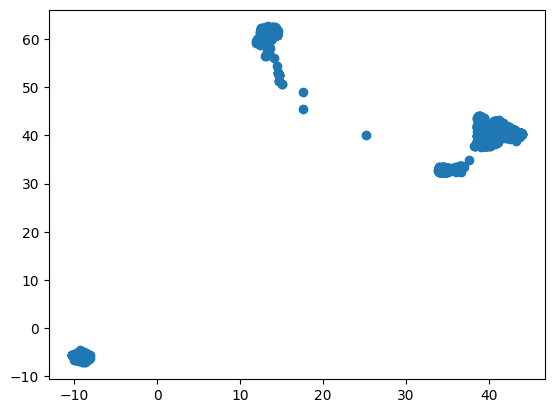

In [8]:
from matplotlib import pyplot as plt
import umap
import pandas as pd
import json
import numpy as np

def create_embedding():
    # read study.csv
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
    
    # read violation_list.json
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_columns = json.load(f)
    
    view_df = study_df[violation_columns] # view of study dataframe with only violation columns

    print("Creating UMAP embedding... (this may take some time)")
    reducer = umap.UMAP(n_neighbors=int(np.sqrt(len(view_df))), min_dist=0.1, n_components=2, random_state=0, verbose=True)
    embedding = reducer.fit_transform(view_df) # 2D projection

    study_df["x"] = embedding[:, 0]
    study_df["y"] = embedding[:, 1]

    study_df.to_csv(STUDY_CSV_FILE)
    print("UMAP embedding created and saved to", STUDY_CSV_FILE)
    

def plot_embedding():
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    plt.scatter(study_df["x"], study_df["y"])
    plt.show()

create_embedding()
plot_embedding()


In [ ]:
# TODO process ontology to differentiate between nan values: relation cannot exist given ontology, or relation is actually missing. also potentially that there is a relation when there shouldn't be but that would me more difficult to handle in the data afterwards